In [61]:
# libs need for project

#numpy
import numpy as np
#scipy
import scipy as sp
#matplotlib
import matplotlib.pyplot as plt
#Pillow import all
from PIL import Image


#sci-kit learn
import sklearn as sk
#sci-kit image
import skimage as ski
#pytorch and tensor flow
import torch
import tensorflow as tf
import os

# import cv2
import cv2


The below block of code is use to mount google drive to colab.

In [62]:
#from google.colab import drive
#drive.mount('/content/drive')

In [63]:
# this is code for the AI part of the project

def convert_to_grayscale(input_folder, output_folder):
    # it could be folder or file

    # check if the input is a folder
    if os.path.isdir(input_folder):
        # get all files in the folder
        files = os.listdir(input_folder)
        # loop through all files
        for file in files:
            # get the file path
            file_path = os.path.join(input_folder, file)
            # read the image
            img = cv2.imread(file_path)
            # convert the image to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # save the image
            cv2.imwrite(os.path.join(output_folder, file), gray)
    # check if the input is a file
    elif os.path.isfile(input_folder):
        # read the image
        img = cv2.imread(input_folder)
        # convert the image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # save the image
        cv2.imwrite(output_folder, gray)



Same thing as above but convert it to hsv

In [64]:
# conevert pic to HSV or HSL
def convert_to_hsv(input_folder, output_folder):
    # it could be folder or file

    # check if the input is a folder
    if os.path.isdir(input_folder):
        # get all files in the folder
        files = os.listdir(input_folder)
        # loop through all files
        for file in files:
            # get the file path
            file_path = os.path.join(input_folder, file)
            # read the image
            img = cv2.imread(file_path)
            # convert the image to HSV
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            # save the image
            cv2.imwrite(os.path.join(output_folder, file), hsv)

    # check if the input is a file
    elif os.path.isfile(input_folder):
        # read the image
        img = cv2.imread(input_folder)
        # convert the image to HSV
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        # save the image
        cv2.imwrite(output_folder, hsv)



Same as above but convert to hsl

In [65]:
def convert_to_hsl(input_folder, output_folder):
    # check if the input is a folder
    if os.path.isdir(input_folder):
        # get all files in the folder
        files = os.listdir(input_folder)
        # loop through all files
        for file in files:
            # get the file path
            file_path = os.path.join(input_folder, file)
            # read the image
            img = cv2.imread(file_path)
            # convert the image to HSV
            hsl = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
            # save the image
            cv2.imwrite(os.path.join(output_folder, file), hsl)

    # check if the input is a file
    elif os.path.isfile(input_folder):
        # read the image
        img = cv2.imread(input_folder)
        # convert the image to HSV
        hsl = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        # save the image
        cv2.imwrite(output_folder, hsl)

In [66]:
# fucntion to Resizing and Cropping: to ensure uniform size for training and manipulation
def resize_and_crop(input_folder, output_folder, size):
    # it could be folder or file

    # check if the input is a folder
    if os.path.isdir(input_folder):
        # get all files in the folder
        files = os.listdir(input_folder)
        # loop through all files
        for file in files:
            # get the file path
            file_path = os.path.join(input_folder, file)
            # read the image
            img = cv2.imread(file_path)
            # resize the image
            img = cv2.resize(img, size)
            # save the image
            cv2.imwrite(os.path.join(output_folder, file), img)
    # check if the input is a file
    elif os.path.isfile(input_folder):
        # read the image
        img = cv2.imread(input_folder)
        # resize the image
        img = cv2.resize(img, size)
        # save the image
        cv2.imwrite(output_folder, img)

In [67]:
from numpy.fft import fft2, fftshift, ifft2

def frequency_analysis(image):
    # Apply Fourier Transform
    f_transform = fft2(image)
    f_shift = fftshift(f_transform)

    # Magnitude Spectrum
    magnitude_spectrum = 20 * np.log(np.abs(f_shift) + 1)

    return magnitude_spectrum


In [68]:
def local_std_deviation(image, kernel_size=3): # use kernel 3 for detail and 7 for smooth

    # Calculate local standard deviation
    local_mean = cv2.blur(image, (kernel_size, kernel_size))
    local_mean_sq = cv2.blur(np.square(image), (kernel_size, kernel_size))
    local_std = np.sqrt(local_mean_sq - np.square(local_mean))

    return local_std

In [69]:
def estimate_noise(image):
    # Ensure the image is grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) > 2 else image

    # Compute the Laplacian (2nd derivative) of the image
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)

    # The variance of the Laplacian is a good estimator for noise
    return np.sqrt(np.var(laplacian))

we use this quantify_noise function to calculate the noise in the image

In [70]:
def quantify_noise(noise_map):
    total_pixels = noise_map.size
    noise_pixels = np.sum(noise_map)
    noise_percentage = (noise_pixels / total_pixels) * 100
    return noise_percentage

adaptive calculate the threshold value for a pixel based on a small region around it. So we get different thresholds for different regions of the same image which gives better results for images with varying illumination.
and also make the nosie map to apply the denoising later on

In [71]:
def adaptive_threshold_detection(image, scale_factor=0.5):
    # Convert to grayscale if not already
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) > 2 else image

    # Calculate local standard deviation and adaptive threshold
    local_std = local_std_deviation(image)
    adaptive_threshold = local_std / np.mean(local_std) * scale_factor

    # Perform frequency analysis and calculate noise
    magnitude_spectrum = frequency_analysis(image)
    # we do the division to normalize the magnitude_spectrum
    noise = np.divide(magnitude_spectrum, local_std, out=np.zeros_like(magnitude_spectrum), where=local_std!=0)
    noise = (noise > adaptive_threshold).astype(int) # Thresholding that we set it to 1 if the noise is greater than the threshold
    # and 0 otherwise

    return noise

In [72]:
# from the result of the noise level assessment (noise map), we can determine the level of noise in the image and apply the appropriate noise reduction technique
# function to denoising the image

def denoise_image(image, noise_map, sigma_color=75, sigma_space=75):
    # Compute the mean noise of the image
    mean_noise = np.mean(noise_map)

    # Adjust the filter parameters based on mean noise
    adjusted_sigma_color = sigma_color * mean_noise
    adjusted_sigma_space = sigma_space * mean_noise

    # Apply bilateral filter to the entire image
    denoised_image = cv2.bilateralFilter(image, d=-1, sigmaColor=adjusted_sigma_color, sigmaSpace=adjusted_sigma_space)

    return denoised_image


In [73]:
def denoise_color_image(color_image, noise_map, sigma_color=75, sigma_space=75):
    # Split the color image into its component channels
    b, g, r = cv2.split(color_image)

    # Denoise each channel using the noise map
    denoised_b = denoise_image(b, noise_map, sigma_color, sigma_space)
    denoised_g = denoise_image(g, noise_map, sigma_color, sigma_space)
    denoised_r = denoise_image(r, noise_map, sigma_color, sigma_space)

    # Merge the channels back together
    denoised_color_image = cv2.merge((denoised_b, denoised_g, denoised_r))

    return denoised_color_image


In [74]:
from skimage.metrics import structural_similarity

def calculate_metrics(original, denoised):
    # Calculate PSNR, specifying the range of pixel values
    data_range = original.max() - original.min()  # If range is not standard, calculate from images
    # Calculate SSIM
    ssim = structural_similarity(original, denoised, data_range=data_range)
    # the higehr it is the better the denoised images is but we need to be aware of over blurring

    return ssim


In [75]:
# do adaptive histogram equalization to improve the contrast and brightness of the image

def adaptive_histogram_equalization(image, contrastThreshold, gridSize):

    # Convert to grayscale if not already
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) > 2 else image
    assert img is not None, "file could not be read, check with os.path.exists()"

    # Create a CLAHE object (higher contrastThreshold means higher contrast variability)
    clahe = cv2.createCLAHE(contrastThreshold, gridSize)
    cl1 = clahe.apply(img)
    return cl1

In [76]:
# do edge detection to detect any scratches or defects on the image
def edge_detection(image, lowerThreshold, upperThreshold):
  # Convert to grayscale if not already
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) > 2 else image
    assert img is not None, "file could not be read, check with os.path.exists()"

  # Get edges using Canny edge detection, adjust threshold bounds as needed
    edges = cv2.Canny(img,lowerThreshold,upperThreshold)
    return edges


In [77]:
import cv2
import numpy as np

def fill_holes(edge_mask, max_distance=10):
    # Create a copy of the edge mask
    filled_mask = edge_mask.copy()

    # Find coordinates of edge points
    edge_points = np.argwhere(edge_mask > 0)

    # Iterate over edge points
    for point in edge_points:
        # Find nearby points within the specified distance
        nearby_points = np.argwhere(np.linalg.norm(edge_points - point, axis=1) < max_distance)

        # Fill the nearby points
        filled_mask[tuple(edge_points[nearby_points].T)] = 255

    return filled_mask


In [78]:
def detect_scratches(image, lowerThreshold, upperThreshold):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) > 2 else image

    # Get edges using Canny edge detection
    edges = cv2.Canny(gray, lowerThreshold, upperThreshold)

    filled_mask = fill_holes(edges, max_distance=10)  # Fill holes

    # Apply morphological dilation on the filled edge map to enhance edges
    kernel = np.ones((3, 3), np.uint8)
    edges_filled = cv2.dilate(edges, kernel, iterations=1)

    # Apply morphological closing to join nearby edges
    edges_filled = cv2.morphologyEx(edges_filled, cv2.MORPH_CLOSE, kernel)

    # Convert the filled edge map to a scratch mask
    scratch_mask = np.where(edges_filled > 0, 255, 0).astype(np.uint8)

    return scratch_mask


In [79]:
def paint_scratches(image, scratch_mask):
    # Create a copy of the original image to avoid modifying it directly
    img_with_scratches = image.copy()

    # Find coordinates of scratches (where mask is white)
    scratch_coords = np.where(scratch_mask == 255)

    # Paint scratches in red
    img_with_scratches[scratch_coords[0], scratch_coords[1]] = [0, 0, 255]  # BGR color

    return img_with_scratches

In [80]:
def inpaint_scratchs(image, scratch_mask):

  # Inpaint.
  dst = cv2.inpaint(image, scratch_mask, 20, cv2.INPAINT_TELEA)

  return dst


In [81]:
def gamma_correction(image, gamma=1.0):
    # Gamma correction is a process for adjusting the brightness of an image
    # by using a non-linear transformation between the input values and the mapped output values

    # The 'gamma' value is a parameter of this transformation, and it controls the level of correction

    # If gamma < 1, the image will be darker; if gamma > 1, the image will be brighter

    # Calculate the inverse of gamma
    inv_gamma = 1.0 / gamma

    # Create a lookup table for the gamma correction
    # This table maps each pixel value [0, 255] to a new value based on the gamma correction formula
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")

    # Apply gamma correction to the image using the lookup table
    # cv2.LUT is a function that maps an array of pixel values (image) to another array of values (table)
    corrected_image = cv2.LUT(image, table)

    # Return the gamma corrected image
    return corrected_image

In [82]:
def histogram_based_tonemap(image):
    # Ensure image is in the float32 format
    if image.dtype != np.float32:
        image = np.float32(image) / 255.0

    # Check if the image is grayscale
    if len(image.shape) == 2:
        # Convert grayscale to 3-channel image
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Create tonemap using Drago's method
    tonemap = cv2.createTonemapDrago(1.0, 0.7)

    # Apply tone mapping
    tonemapped_image = tonemap.process(image)

    # Normalize the tonemapped image to lie within the valid range
    normalized_image = cv2.normalize(tonemapped_image, None, 0, 1, cv2.NORM_MINMAX)

    # Convert the normalized image back to 8-bit format
    final_image = (normalized_image * 255).astype('uint8')

    return final_image


In [83]:
def histogram_stretching(image):
    # Split into color channels
    b, g, r = cv2.split(image)

    # Apply histogram stretching to each channel
    b_stretched = cv2.normalize(b, None, 0, 255, cv2.NORM_MINMAX)
    g_stretched = cv2.normalize(g, None, 0, 255, cv2.NORM_MINMAX)
    r_stretched = cv2.normalize(r, None, 0, 255, cv2.NORM_MINMAX)

    # Merge channels back
    img_stretched = cv2.merge((b_stretched, g_stretched, r_stretched))

    return img_stretched


In [84]:
def unsharp_mask(image, sigma=1.0, strength=1.5):
    # Use a Gaussian filter to blur the image
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)

    # Calculate the sharpened image
    sharpened = cv2.addWeighted(image, 1.0 + strength, blurred, -strength, 0)

    return sharpened


In [85]:
# Image Sharpening to improve the sharpness of the image or reduce the blurriness of the image
def sharpen(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute the Laplacian of the image and then return the variance
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()

    # If the variance is below a threshold, the image is likely blurry
    if laplacian_var < 10:  # Threshold value, may need to be adjusted or we need new algo taht can detect the blurriness
        # Apply unsharp mask
        sharpened = unsharp_mask(image, sigma=2.0, strength=3.5)
        return sharpened
    else:
        # Image is already sharp or the blurriness is within acceptable range
        return image


In [86]:
# Color Restoration, Correction and Enhancement to improve the color of the image if it is faded or discolored
def color_restoration(image):
    # 1st, use gamme correction to adjust the brightness of the image
    corrected_image = gamma_correction(image, gamma=1.5)

    # then apply histogram stretching to improve the contrast of the image
    stretched_image = histogram_stretching(corrected_image)

    # finally, apply histogram-based tonemapping to enhance the color of the image
    tonemapped_image = histogram_based_tonemap(stretched_image)

    return tonemapped_image

In [ ]:
def adaptive_edge_detection(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) > 2 else image
    # Use Otsu's method to find the optimal threshold automatically
    _, threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    edges = cv2.Canny(gray, 0.5 * threshold, threshold)
    return edges


In [ ]:
def dynamic_dilate(edges, image):
    kernel_size = max(3, min(image.shape[0], image.shape[1]) // 100)  # kernel size as a fraction of image size
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=1)
    return dilated


In [ ]:
def dynamic_inpaint(image, mask):
    defect_density = np.sum(mask) / mask.size
    radius = int(5 + 15 * defect_density)  # Adjust radius based on defect density
    inpainted_image = cv2.inpaint(image, mask, radius, cv2.INPAINT_TELEA)
    return inpainted_image


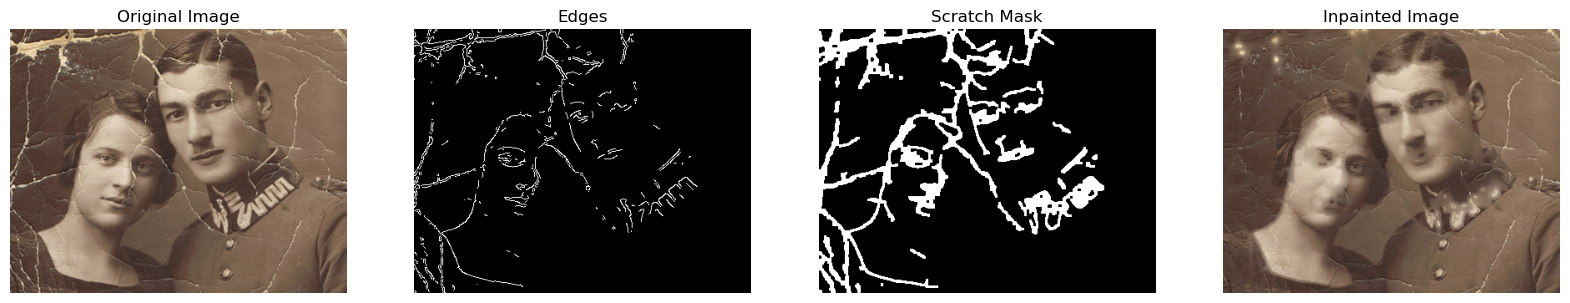

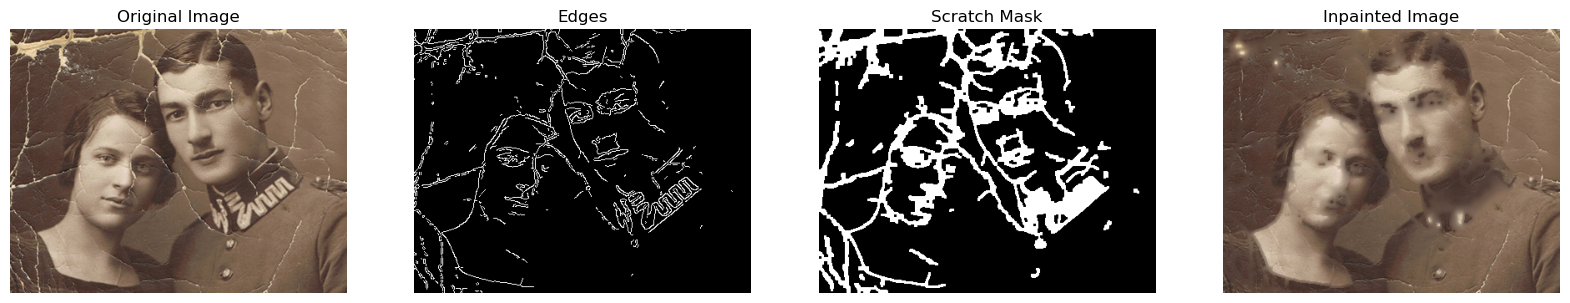

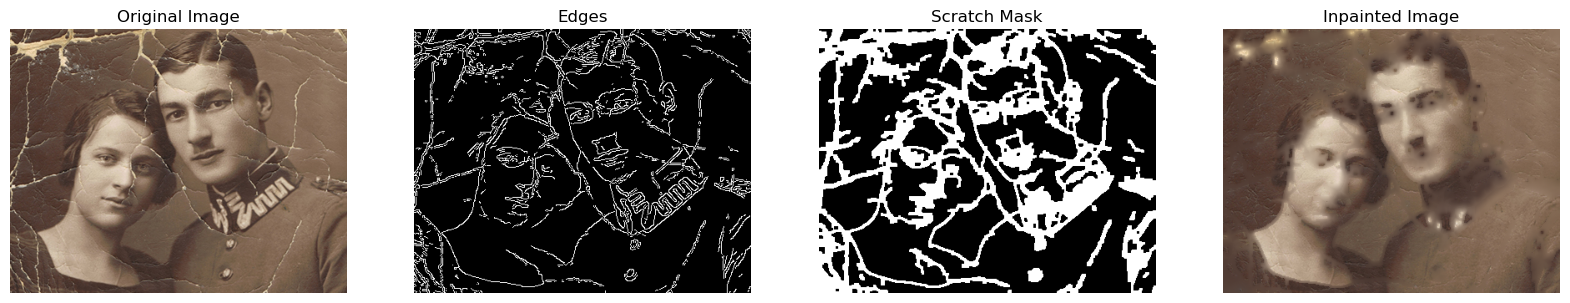

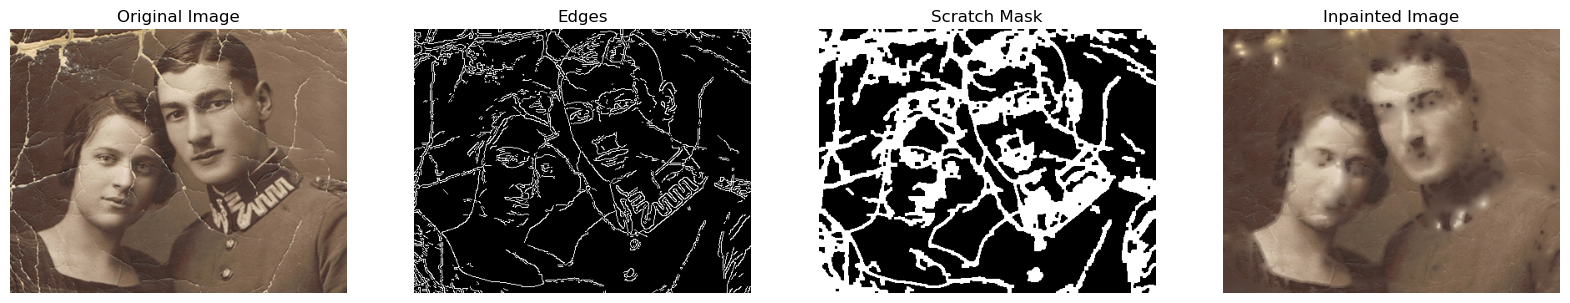

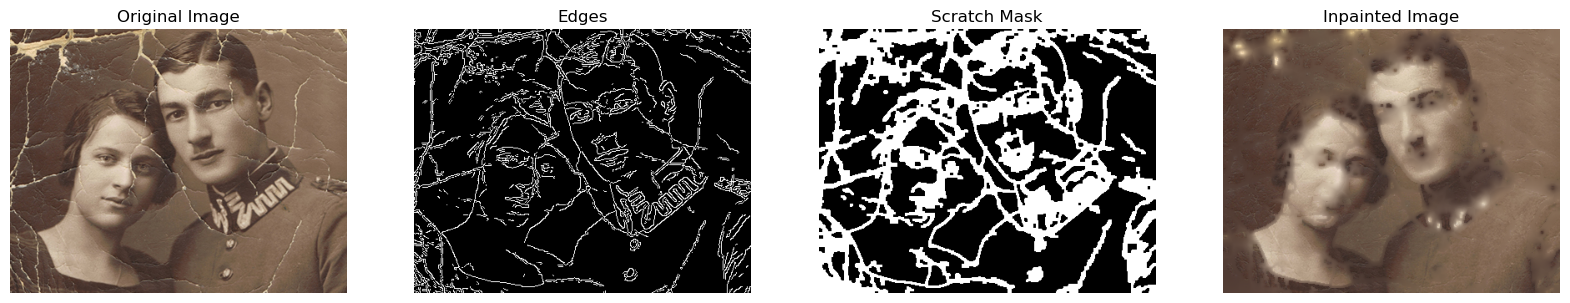

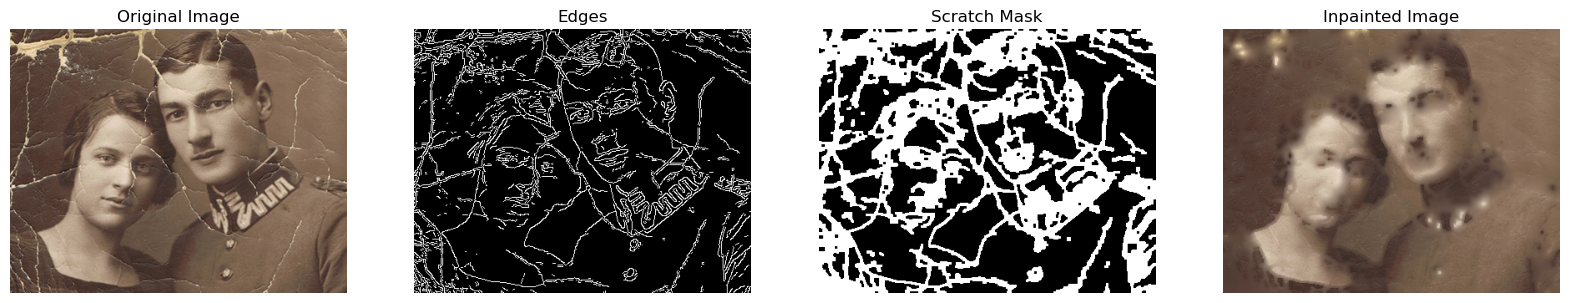

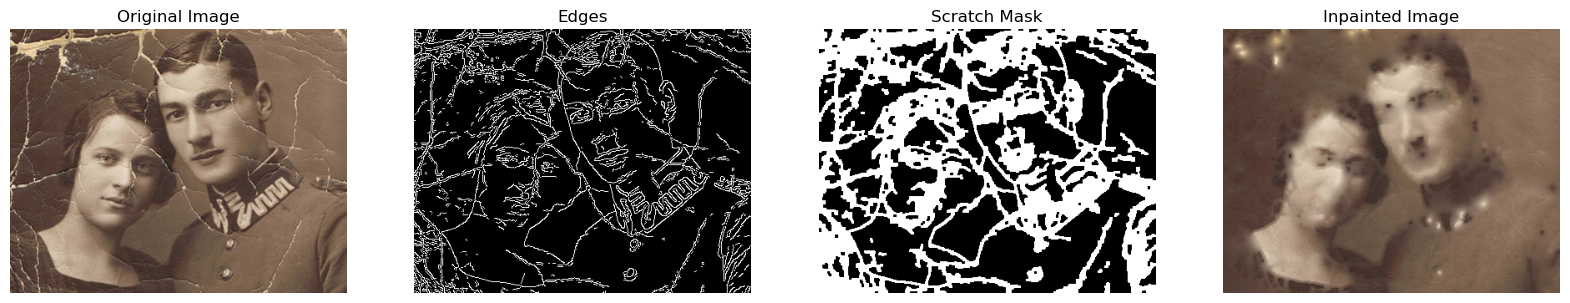

In [87]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load the image in color and grayscale
color_img = cv2.imread('3785cc56082559.Y3JvcCwxMDM2LDgxMCwxMzMsMjA.jpg', cv2.IMREAD_COLOR)
gray_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)

if color_img is None or gray_img is None:
    raise FileNotFoundError("The specified image path does not exist.")

scale_factors = [1, 10, 50, 80, 100, 150, 200]
for scale in scale_factors:
    # Perform processing on the grayscale image
    noise_map = adaptive_threshold_detection(gray_img, scale_factor=scale)
    denoised_gray = denoise_image(gray_img, noise_map)
    equalized_gray = adaptive_histogram_equalization(denoised_gray, 2.0, (8,8))
    # edges = edge_detection(equalized_gray, 150, 200)
# 
    # scratch_mask = detect_scratches(equalized_gray, 100, 200)
    # painted = inpaint_scratchs(color_img,scratch_mask)

    edges = adaptive_edge_detection(equalized_gray)
    dilated_edges = dynamic_dilate(edges, color_img)
    scratch_mask = detect_scratches(equalized_gray, 100, 200)
    inpainted = dynamic_inpaint(color_img, scratch_mask)

    # Convert the grayscale results back to BGR for color processing (if necessary)
    equalized_color = cv2.cvtColor(equalized_gray, cv2.COLOR_GRAY2BGR)

    # Apply the same transformations or use the insights on the color image
    # denoised_color = denoise_color_image(color_img, noise_map, sigma_color=75, sigma_space=75)
    # call the color restoration function
    # tonemapped = color_restoration(denoised_color)
    # sharpen the image
    # sharpened = sharpen(tonemapped)


    # Calculate metrics based on the grayscale processing
    # original = gray_img.astype(np.float32)
    # denoised = denoised_gray.astype(np.float32)
    # ssim = calculate_metrics(original, denoised)
    # print(f"Scale Factor: {scale}, SSIM: {ssim}")

    # Visualization
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB))  # Original color image
    axes[1].imshow(edges, cmap='gray')  # Edges
    axes[2].imshow(scratch_mask, cmap='gray')  # Denoised grayscale image
    axes[3].imshow(cv2.cvtColor(painted, cv2.COLOR_BGR2RGB))  # Original color image

    for ax in axes:
        ax.axis('off')
        # set the title of the image
    axes[0].set_title("Original Image")
    axes[1].set_title("Edges")
    axes[2].set_title("Scratch Mask")
    axes[3].set_title("Inpainted Image")

    plt.show()

In [88]:
"""import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load the image in color and grayscale
color_img = cv2.imread('/content/drive/MyDrive/469/scratch-photo.jpg', cv2.IMREAD_COLOR)
gray_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)

if color_img is None or gray_img is None:
    raise FileNotFoundError("The specified image path does not exist.")

scale_factors = [1, 10, 50, 80, 100, 150, 200]
for scale in scale_factors:
    # Perform processing on the grayscale image
    noise_map = adaptive_threshold_detection(gray_img, scale_factor=scale)
    denoised_gray = denoise_image(gray_img, noise_map)
    equalized_gray = adaptive_histogram_equalization(denoised_gray, 2.0, (8,8))
    edges = edge_detection(equalized_gray, 150, 200)
    scratch_mask = detect_scratches(color_img, 150, 200)
    # paint_scratches_img = paint_scratches(color_img,scratch_mask)
    painted = inpaint_scratchs(color_img, scratch_mask);

    # Convert the grayscale results back to BGR for color processing (if necessary)
    equalized_color = cv2.cvtColor(equalized_gray, cv2.COLOR_GRAY2BGR)

    # Apply the same transformations or use the insights on the color image
    denoised_color = denoise_color_image(color_img, noise_map, sigma_color=75, sigma_space=75)
    # call the color restoration function
    tonemapped = color_restoration(denoised_color)
    # sharpen the image
    sharpened = sharpen(tonemapped)


    # Calculate metrics based on the grayscale processing
    original = gray_img.astype(np.float32)
    denoised = denoised_gray.astype(np.float32)
    ssim = calculate_metrics(original, denoised)
    print(f"Scale Factor: {scale}, SSIM: {ssim}")

    # Visualization
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB))  # Original color image
    axes[1].imshow(edges, cmap='gray')  # Edges
    axes[2].imshow(scratch_mask, cmap='gray')  # Denoised grayscale image
    axes[3].imshow(cv2.cvtColor(painted, cv2.COLOR_BGR2RGB))

    for ax in axes:
        ax.axis('off')
        # set the title of the image
    axes[0].set_title("Original Image")
    axes[1].set_title("Edges")
    axes[2].set_title("Scratch Mask")
    axes[3].set_title("Paint Scratches Image")

    plt.show()
"""

'import cv2\nimport matplotlib.pyplot as plt\nimport numpy as np\n\n# Load the image in color and grayscale\ncolor_img = cv2.imread(\'/content/drive/MyDrive/469/scratch-photo.jpg\', cv2.IMREAD_COLOR)\ngray_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)\n\nif color_img is None or gray_img is None:\n    raise FileNotFoundError("The specified image path does not exist.")\n\nscale_factors = [1, 10, 50, 80, 100, 150, 200]\nfor scale in scale_factors:\n    # Perform processing on the grayscale image\n    noise_map = adaptive_threshold_detection(gray_img, scale_factor=scale)\n    denoised_gray = denoise_image(gray_img, noise_map)\n    equalized_gray = adaptive_histogram_equalization(denoised_gray, 2.0, (8,8))\n    edges = edge_detection(equalized_gray, 150, 200)\n    scratch_mask = detect_scratches(color_img, 150, 200)\n    # paint_scratches_img = paint_scratches(color_img,scratch_mask)\n    painted = inpaint_scratchs(color_img, scratch_mask);\n\n    # Convert the grayscale results back to

In [89]:
# optional: reconstruct the image using deep learning techniques

In [90]:
def show_images(folder_path, num_images=9):
    # Get a list of all the image filenames in the folder
    image_filenames = os.listdir(folder_path)

    # Create a 5x5 grid of subplots
    fig, axes = plt.subplots(3, 3, figsize=(6, 6))

    # Loop over the first num_images images
    for i in range(num_images):
        # Create the full path to the image and read it
        img_path = os.path.join(folder_path, image_filenames[i])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Find the subplot to display this image on
        ax = axes[i // 3, i % 3]

        # Display the image on the subplot
        ax.imshow(img, cmap='gray')
        ax.axis('off')

    # Show the plot with all subplots
    plt.show()